In [1]:
from google.colab import files
import zipfile
import os

# Upload zip file
uploaded = files.upload()

# Extract zip file
zip_path = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")

# Path to dataset folder
data_dir = "/content/dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"

# Verify classes
print(os.listdir(data_dir))


Saving CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone.zip to CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone.zip
['Stone', 'Tumor', 'Cyst', 'Normal']


In [2]:

import zipfile
import os

zip_path = "/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone.zip"

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")

# Check extracted folders
print(os.listdir("/content/dataset"))

['CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone']


In [3]:
data_dir = "/content/dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"


In [4]:
import os
print(os.listdir(data_dir))

['Stone', 'Tumor', 'Cyst', 'Normal']


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# ===============================
# 1. MOUNT GOOGLE DRIVE & SET PATHS
# ===============================

# Set your dataset path based on the file structure shown
dataset_path = '/content/dataset/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

# Verify the path and classes
classes = ['Cyst', 'Normal', 'Stone', 'Tumor']
for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    if os.path.exists(class_path):
        num_images = len(os.listdir(class_path))
        print(f"{class_name}: {num_images} images")
    else:
        print(f"Warning: {class_name} folder not found!")

# ===============================
# 2. HYPERPARAMETERS
# ===============================
IMG_SIZE = (224, 224)  # VGG16 input size
BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 0.001
NUM_CLASSES = 4

# ===============================
# 3. DATA PREPROCESSING & AUGMENTATION
# ===============================
# Data augmentation for training (helps prevent overfitting)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 80% train, 20% validation
)

# Only rescaling for validation data
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = val_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

# Display class indices
print("Class indices:", train_generator.class_indices)
print("Number of training samples:", train_generator.samples)
print("Number of validation samples:", validation_generator.samples)


TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Cyst: 1124 images
Normal: 1738 images
Stone: 425 images
Tumor: 671 images
Found 3168 images belonging to 4 classes.
Found 790 images belonging to 4 classes.
Class indices: {'Cyst': 0, 'Normal': 1, 'Stone': 2, 'Tumor': 3}
Number of training samples: 3168
Number of validation samples: 790


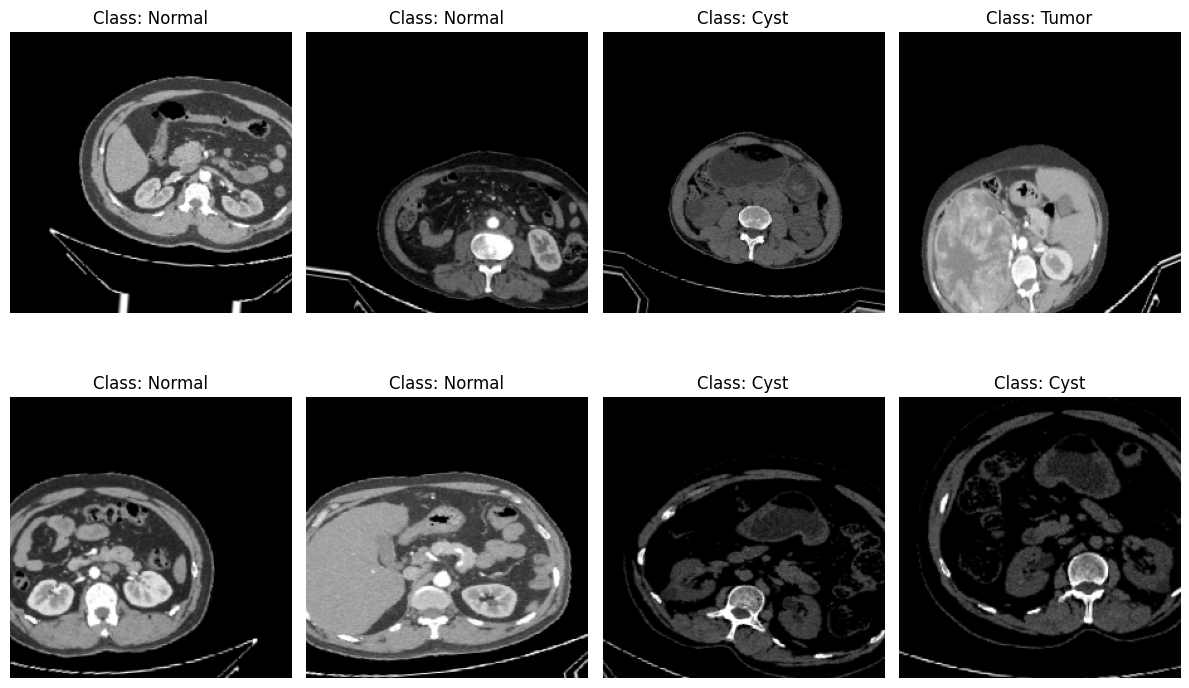

In [6]:
# 4. VISUALIZE SAMPLE IMAGES
# ===============================
def plot_sample_images():
    plt.figure(figsize=(12, 8))
    sample_batch = next(train_generator)
    images, labels = sample_batch

    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i])

        # Get class name from label
        class_idx = np.argmax(labels[i])
        class_names = list(train_generator.class_indices.keys())
        plt.title(f'Class: {class_names[class_idx]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Plot sample images
plot_sample_images()


In [7]:
# 5. BUILD VGG16 MODEL
# ===============================
# Load pretrained VGG16 model without top classification layers
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze the base model layers (transfer learning)
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [8]:
# 6. COMPILE MODEL
# ===============================
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,109,700 (57.64 MB)

 Trainable params: 395,012 (1.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
# 7. SETUP CALLBACKS
# ===============================
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

# ===============================
# 8. TRAIN THE MODEL
# ===============================
print("Starting training...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

# ===============================
# 9. FINE-TUNING (OPTIONAL)
# ===============================
print("\nStarting fine-tuning...")

# Unfreeze the top layers of VGG16 for fine-tuning
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all layers before fine_tune_at
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE/10),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training with fine-tuning
fine_tune_epochs = 10
total_epochs = len(history.history['loss']) + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=total_epochs,
    initial_epoch=len(history.history['loss']),
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Starting training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 65s 496ms/step - accuracy: 0.4484 - loss: 1.2642 - val_accuracy: 0.5586 - val_loss: 0.9694 - learning_rate: 0.0010
Epoch 2/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 48s 481ms/step - accuracy: 0.6830 - loss: 0.8239 - val_accuracy: 0.6289 - val_loss: 0.8854 - learning_rate: 0.0010
Epoch 3/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 82s 480ms/step - accuracy: 0.7749 - loss: 0.6037 - val_accuracy: 0.6576 - val_loss: 1.0299 - learning_rate: 0.0010
Epoch 4/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 48s 482ms/step - accuracy: 0.8218 - loss: 0.4738 - val_accuracy: 0.4987 - val_loss: 1.2228 - learning_rate: 0.0010
Epoch 5/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.8610 - loss: 0.4048
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
99/99 ━━━━━━━━━━━━━━━━━━━━ 82s 828ms/step - accuracy: 0.8609 - loss: 0.4048 - val_accuracy: 0.5469 - val_loss: 1.0658 - learning_rate: 0.0010
Epoch 6/25
99/99 ━━━━━━━━━━━━━━━━━━━━ 108s 482ms/step - accuracy: 0.8891 - loss: 0.

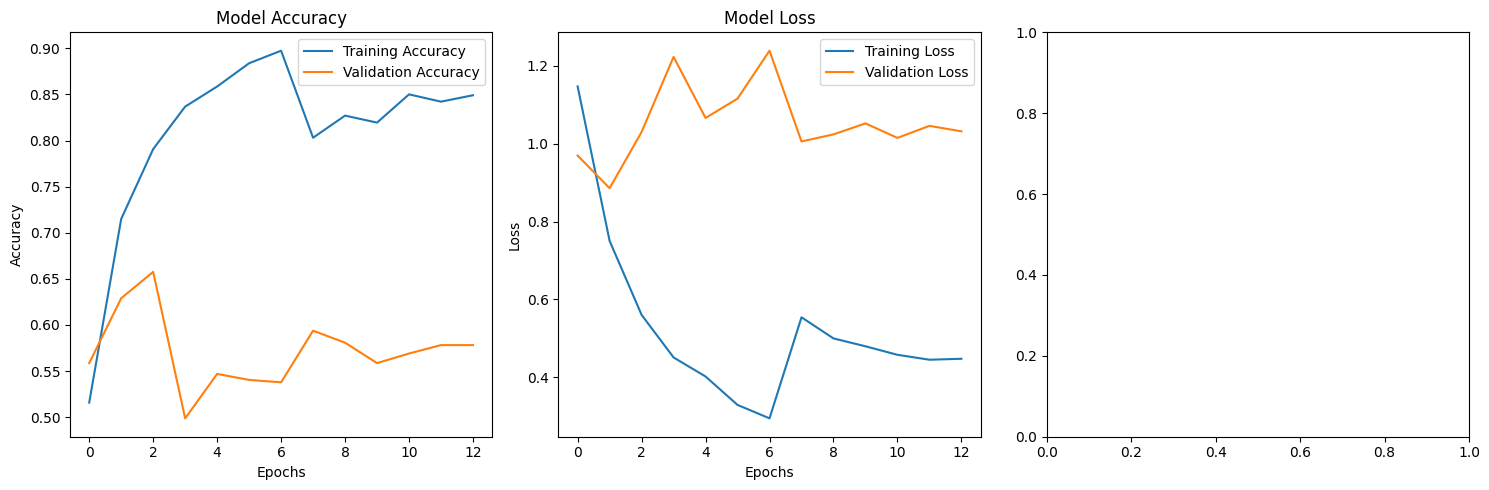

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step

Classification Report:
              precision    recall  f1-score   support

        Cyst       0.67      0.29      0.41       224
      Normal       0.79      0.84      0.81       347
       Stone       0.35      0.11      0.16        85
       Tumor       0.37      0.83      0.51       134

    accuracy                           0.60       790
   macro avg       0.55      0.52      0.47       790
weighted avg       0.64      0.60      0.58       790



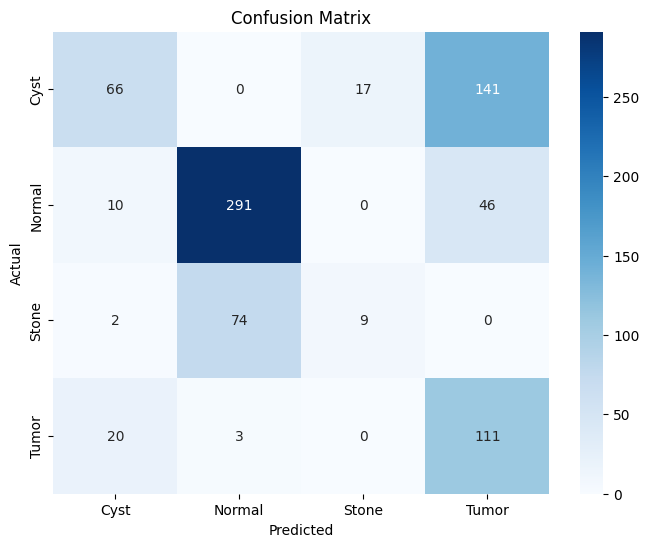

Cyst accuracy: 0.295
Normal accuracy: 0.839
Stone accuracy: 0.106
Tumor accuracy: 0.828
Model saved successfully!

Final Model Performance:
Validation Loss: 0.9904
Validation Accuracy: 0.6038

Project completed successfully!


In [11]:
# 10. PLOT TRAINING HISTORY
# ===============================
def plot_training_history(history, history_fine=None):
    plt.figure(figsize=(15, 5))

    # Combine histories if fine-tuning was done
    if history_fine:
        acc = history.history['accuracy'] + history_fine.history['accuracy']
        val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
        loss = history.history['loss'] + history_fine.history['loss']
        val_loss = history.history['val_loss'] + history_fine.history['val_loss']
        epochs_range = range(len(acc))
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs_range = range(len(acc))

    # Plot accuracy
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot learning rate (if available)
    plt.subplot(1, 3, 3)
    if 'lr' in history.history:
        lr = history.history['lr']
        if history_fine and 'lr' in history_fine.history:
            lr = lr + history_fine.history['lr']
        plt.plot(epochs_range, lr)
        plt.title('Learning Rate')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history, history_fine)

# ===============================
# 11. EVALUATE MODEL
# ===============================
# Get predictions on validation set
validation_generator.reset()
predictions = model.predict(validation_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion Matrix
def plot_confusion_matrix(true_classes, predicted_classes, class_labels):
    cm = confusion_matrix(true_classes, predicted_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Calculate accuracy for each class
    for i, class_name in enumerate(class_labels):
        class_accuracy = cm[i, i] / np.sum(cm[i, :])
        print(f"{class_name} accuracy: {class_accuracy:.3f}")

plot_confusion_matrix(true_classes, predicted_classes, class_labels)

# ===============================
# 12. MAKE PREDICTIONS ON NEW IMAGES
# ===============================
def predict_single_image(image_path, model, class_labels):
    """Predict class for a single image"""
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) / 255.0

    prediction = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(prediction)
    predicted_class = class_labels[predicted_class_idx]
    confidence = prediction[0][predicted_class_idx]

    # Display results
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f'Input Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.bar(class_labels, prediction[0])
    plt.title(f'Prediction: {predicted_class}\nConfidence: {confidence:.3f}')
    plt.ylabel('Probability')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    return predicted_class, confidence

# Example usage (replace with actual image path):
# predicted_class, confidence = predict_single_image('/path/to/test/image.jpg', model, class_labels)

# ===============================
# 13. SAVE THE MODEL
# ===============================
# Save the entire model
model.save('/content/drive/MyDrive/vgg16_kidney_classification.h5')
print("Model saved successfully!")

# ===============================
# 14. MODEL PERFORMANCE SUMMARY
# ===============================
# Final evaluation
final_loss, final_accuracy = model.evaluate(validation_generator, verbose=0)
print(f"\nFinal Model Performance:")
print(f"Validation Loss: {final_loss:.4f}")
print(f"Validation Accuracy: {final_accuracy:.4f}")

print("\nProject completed successfully!")